In [10]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os
from sklearn.metrics import mean_squared_error
import plotly.express as px
import scipy.stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def plot_line_with_std(data, color, label=''):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    ax.plot(mean,alpha=1, label=label, color=color)
    ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)
    ax.legend(frameon=False, bbox_to_anchor=[1.6,1])
    return ax

In [12]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [13]:
cell_lines = ['PC-3', 'GM12878', 'K562']
model_name = 'enformer'

_, cre_tiles = utils.set_tile_range(custom_model.Enformer().seq_length, 5000)
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/higher_order_test/')

In [23]:
result_summary = {}
location_maps = {}

for cell_line in cell_lines:
    # location_map = [0 for _ in range(len(cre_tiles))]
    location_maps[cell_line] = {}
    cell_line_res_paths = glob.glob(f'../results/higher_order_test_min/{model_name}/{cell_line}/*pickle')
    context_df = pd.read_csv(f'../results/summary_csvs/{model_name}/{cell_line}_selected_contexts.csv')
    traces = {k:[] for k in context_df['context'].unique()}
    hypothetical_traces = {k:[] for k in context_df['context'].unique()}
    location_maps[cell_line] = {k:[] for k in context_df['context'].unique()}
    second_it = {k:[] for k in context_df['context'].unique()}
    sorted_effects = {k:[] for k in context_df['context'].unique()}
    
    print(context_df.shape)
    for _, row in context_df.iterrows():
        res_path = f"../results/higher_order_test_min/{model_name}/{cell_line}/{row['path'].split('/')[-1]}"
        res = utils.read_pickle(res_path)
        wt = res[0]['initial_pred']
        
        traces[row['context']].append([res[i]['initial_pred']/wt for i in res.keys()]) 
        ####hypothetical additive model
        greedy_search_order = [np.argwhere(np.array(cre_tiles) == res[i]['selected_tile'])[0][0] for i in res.keys()]
        first_two_points = res[0]['preds'][greedy_search_order[:2]].mean(axis=1)
        two_cres_shuffled = res[2]['initial_pred']
        second_it[row['context']].append([wt, first_two_points, two_cres_shuffled])

        mutant_predictions_first_iter = res[0]['preds'].mean(axis=-1)
        
        effect_sizes_first_iter = mutant_predictions_first_iter - wt
        sorted_effect_first_iter = effect_sizes_first_iter[greedy_search_order]
        sorted_effects[row['context']].append(sorted_effect_first_iter/wt)
        sum_of_effects = np.cumsum(sorted_effect_first_iter) 
        hypothetical_trace = wt + sum_of_effects
        hypothetical_trace = np.concatenate([[wt], hypothetical_trace]) /wt
        
        hypothetical_traces[row['context']].append(hypothetical_trace[:-1])
        location_map = [0 for _ in range(len(cre_tiles))]
        for iteration in range(5):
            res[iteration]['selected_tile']
            location_map[np.argwhere(res[iteration]['selected_tile'] == np.array(cre_tiles))[0][0]] = 1
        location_maps[cell_line][row['context']].append(location_map)
    result_summary[cell_line] = {'greedy search': traces, 'hypothetical additive': hypothetical_traces,
                                'second_it': second_it, 'sorted_effects': sorted_effects}
    


(400, 9)
(461, 9)
(600, 9)


<StemContainer object of 3 artists>

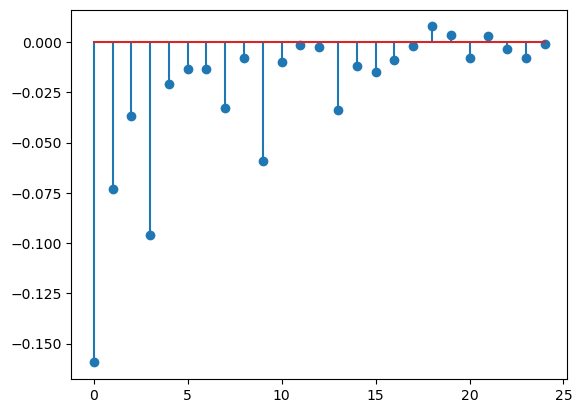

In [25]:
# plt.xticks( my_range, ordered_df['group'])



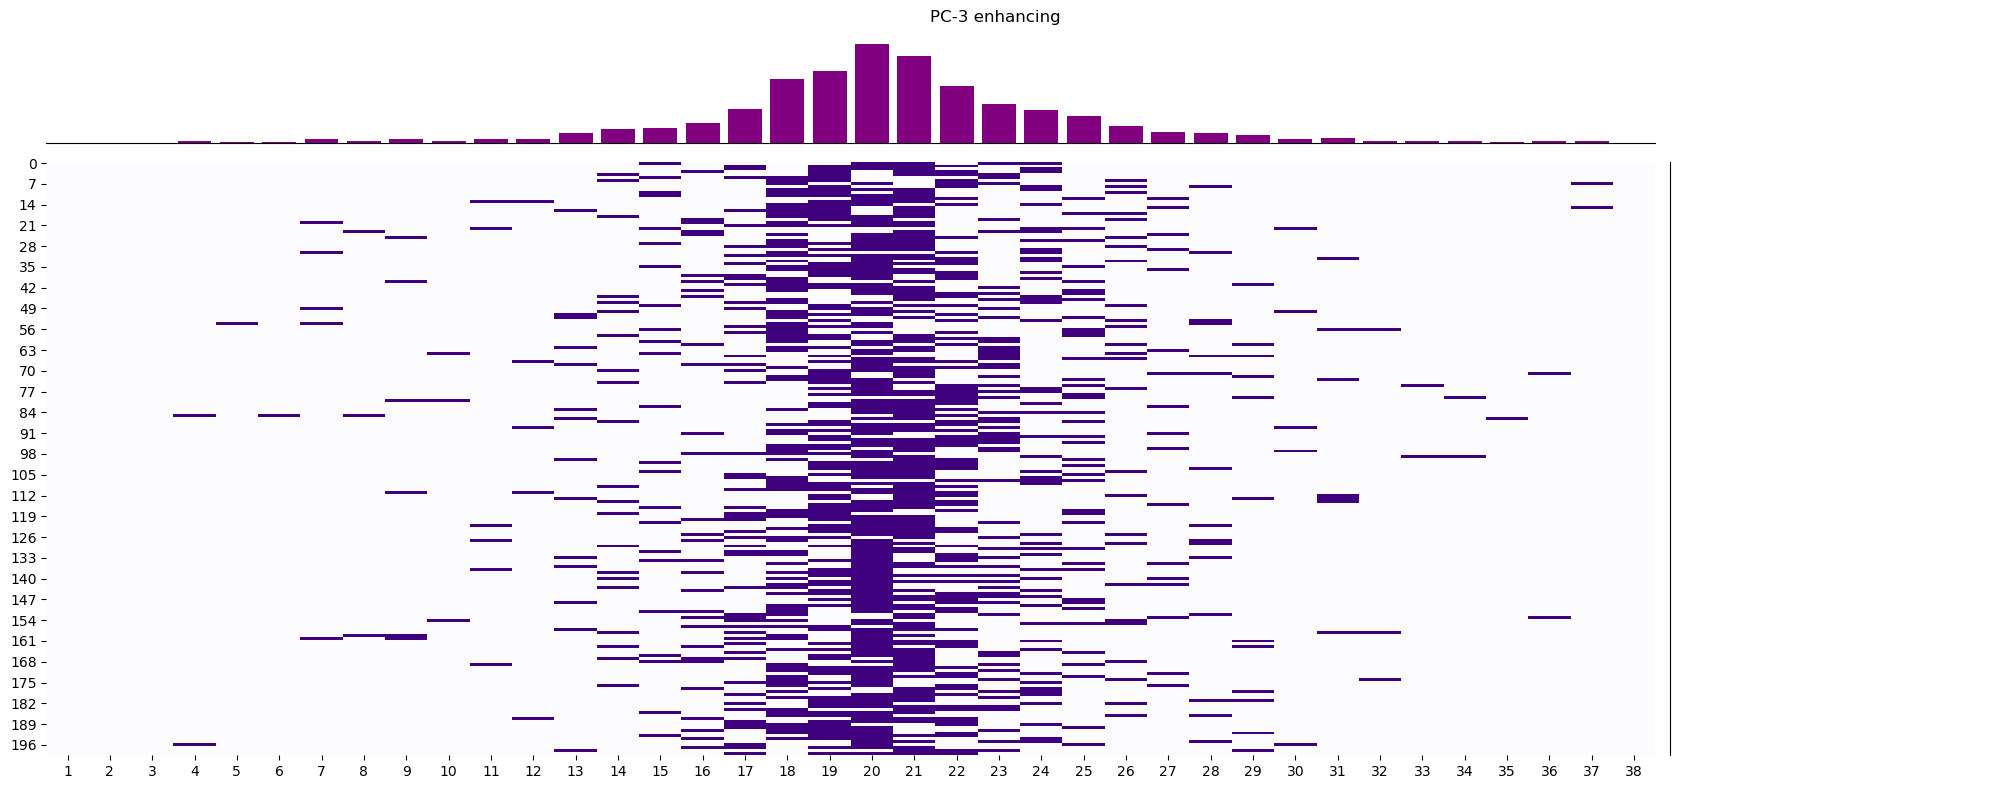

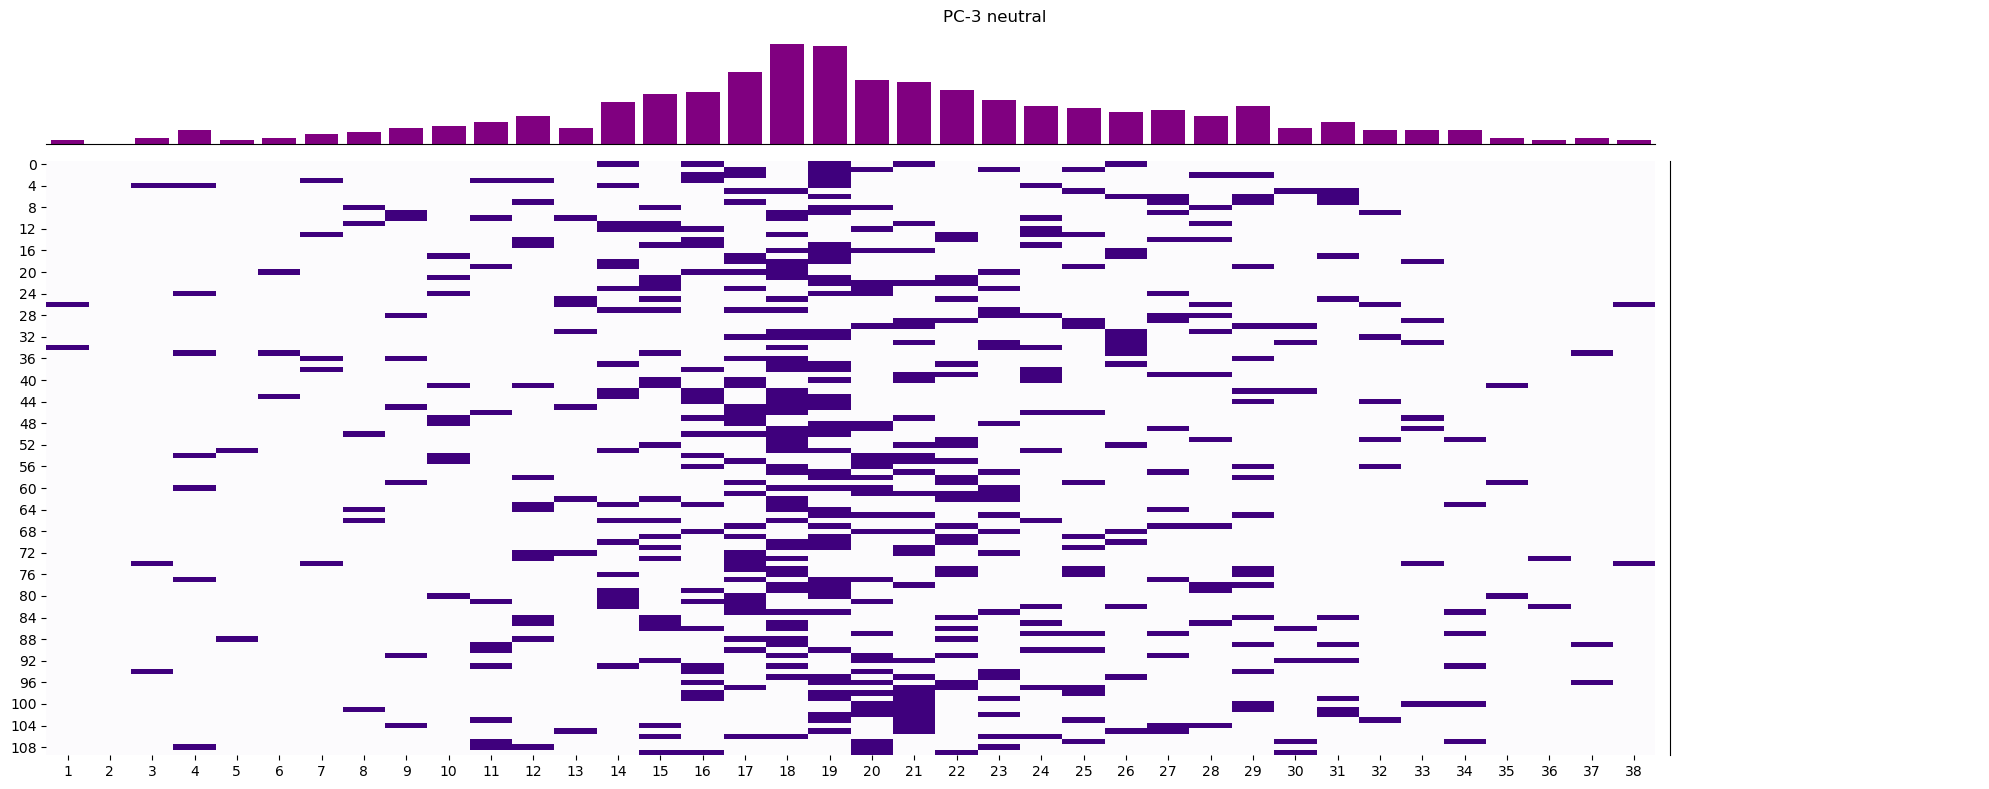

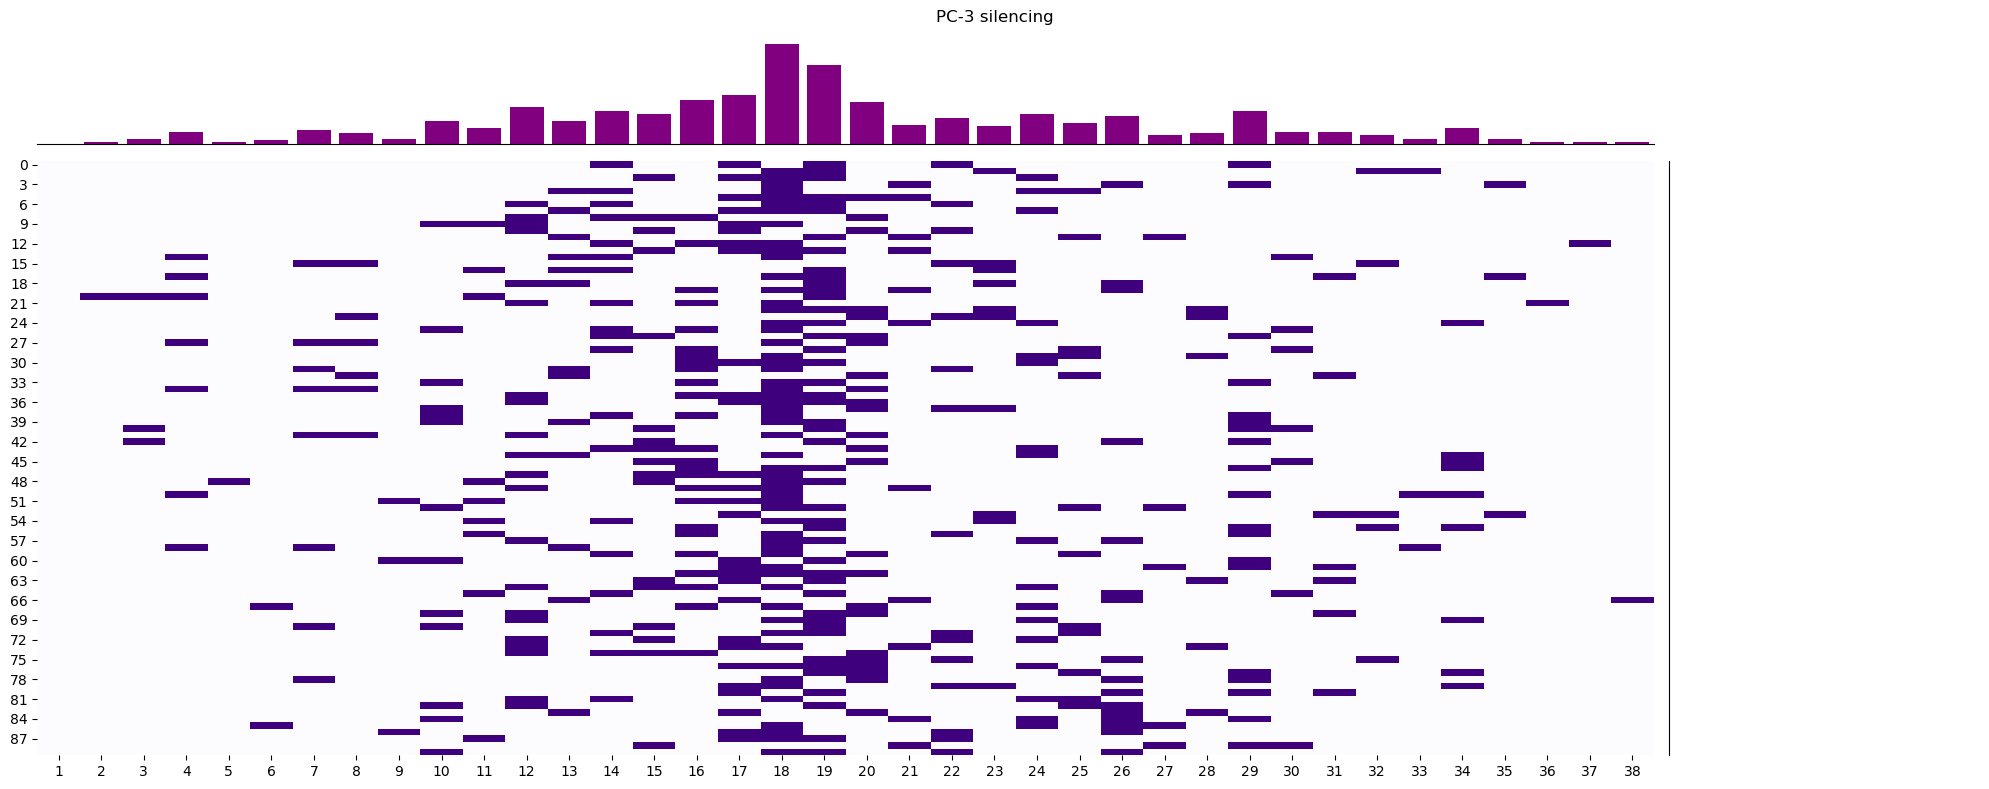

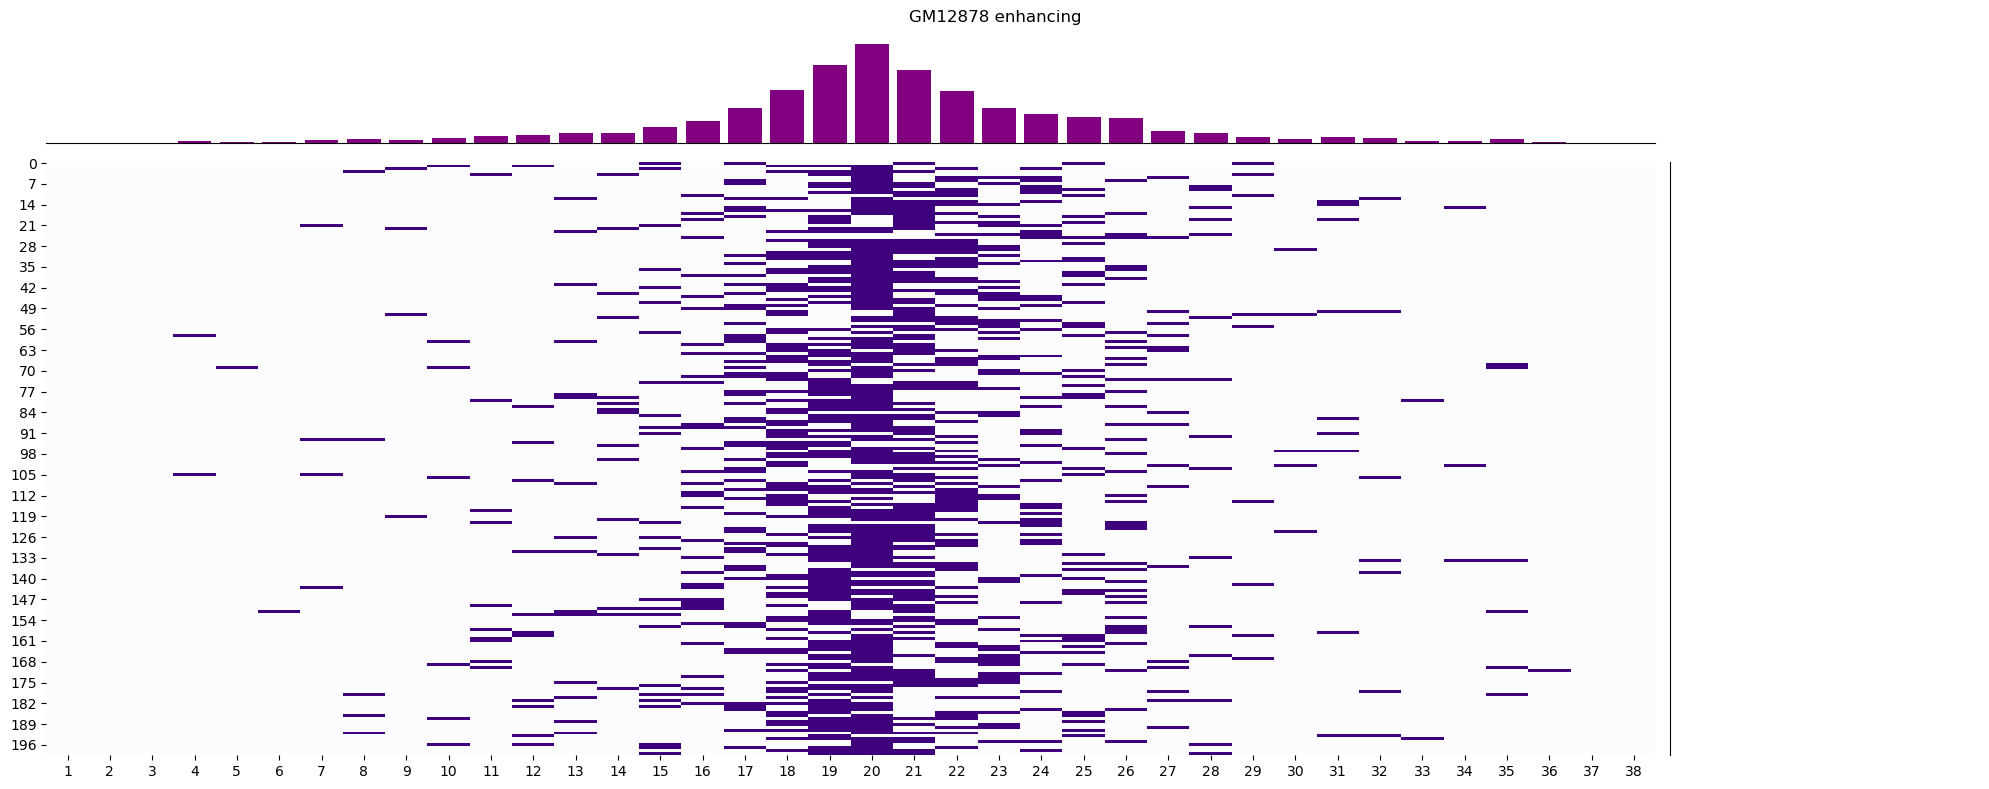

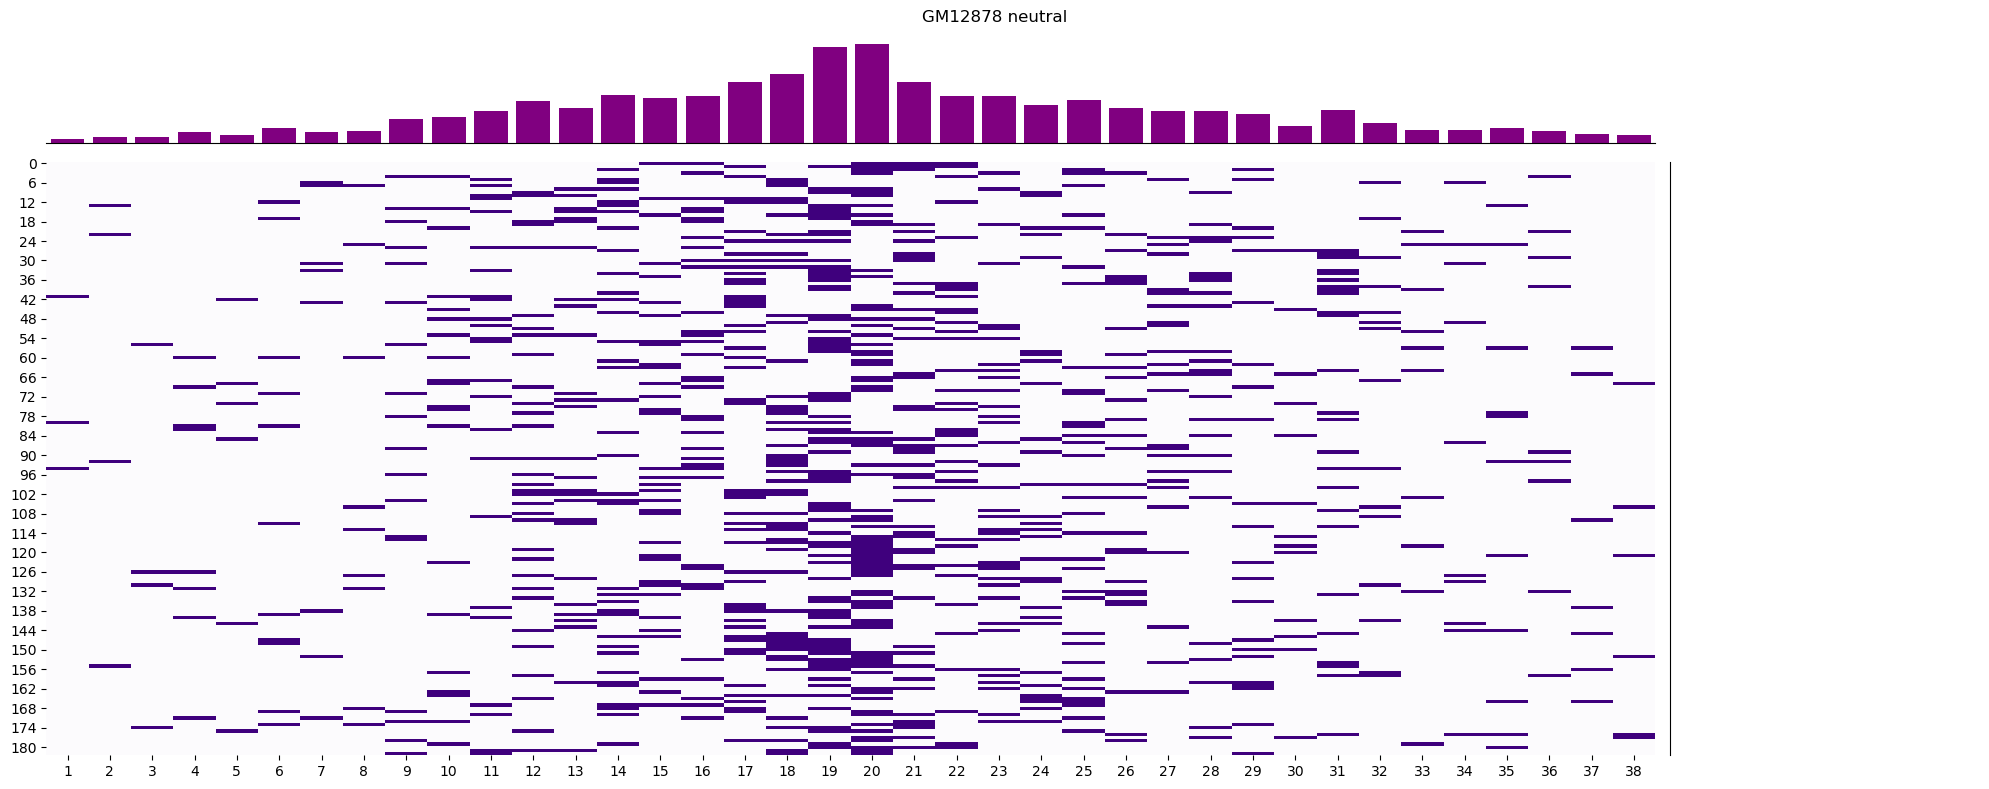

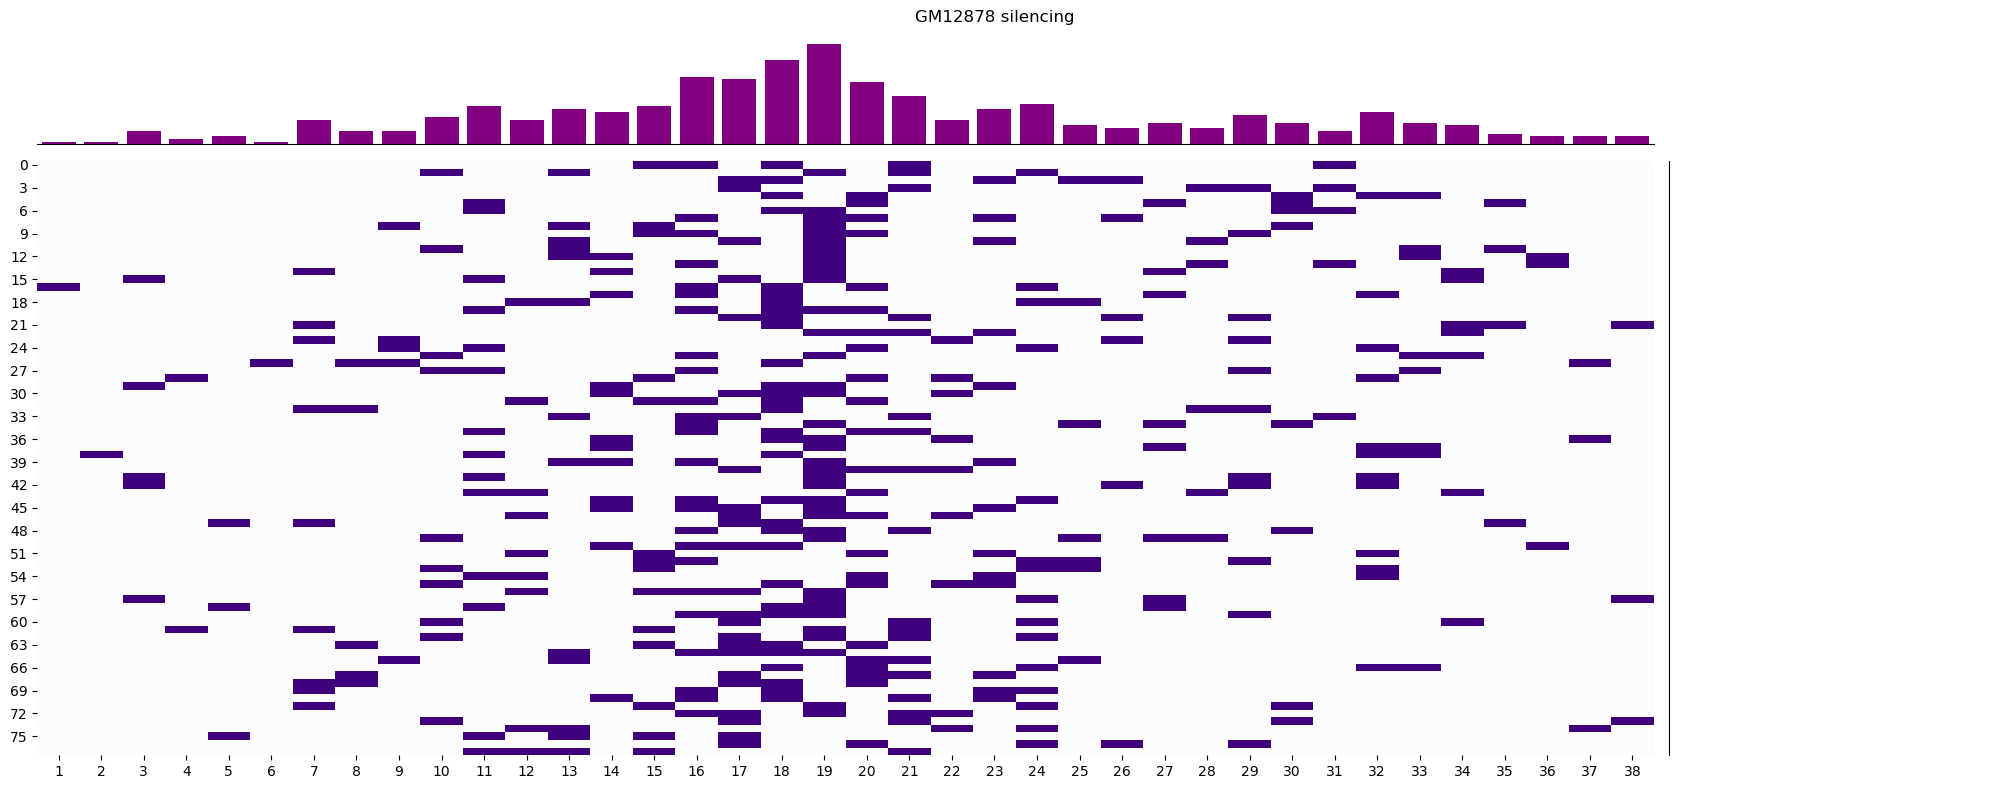

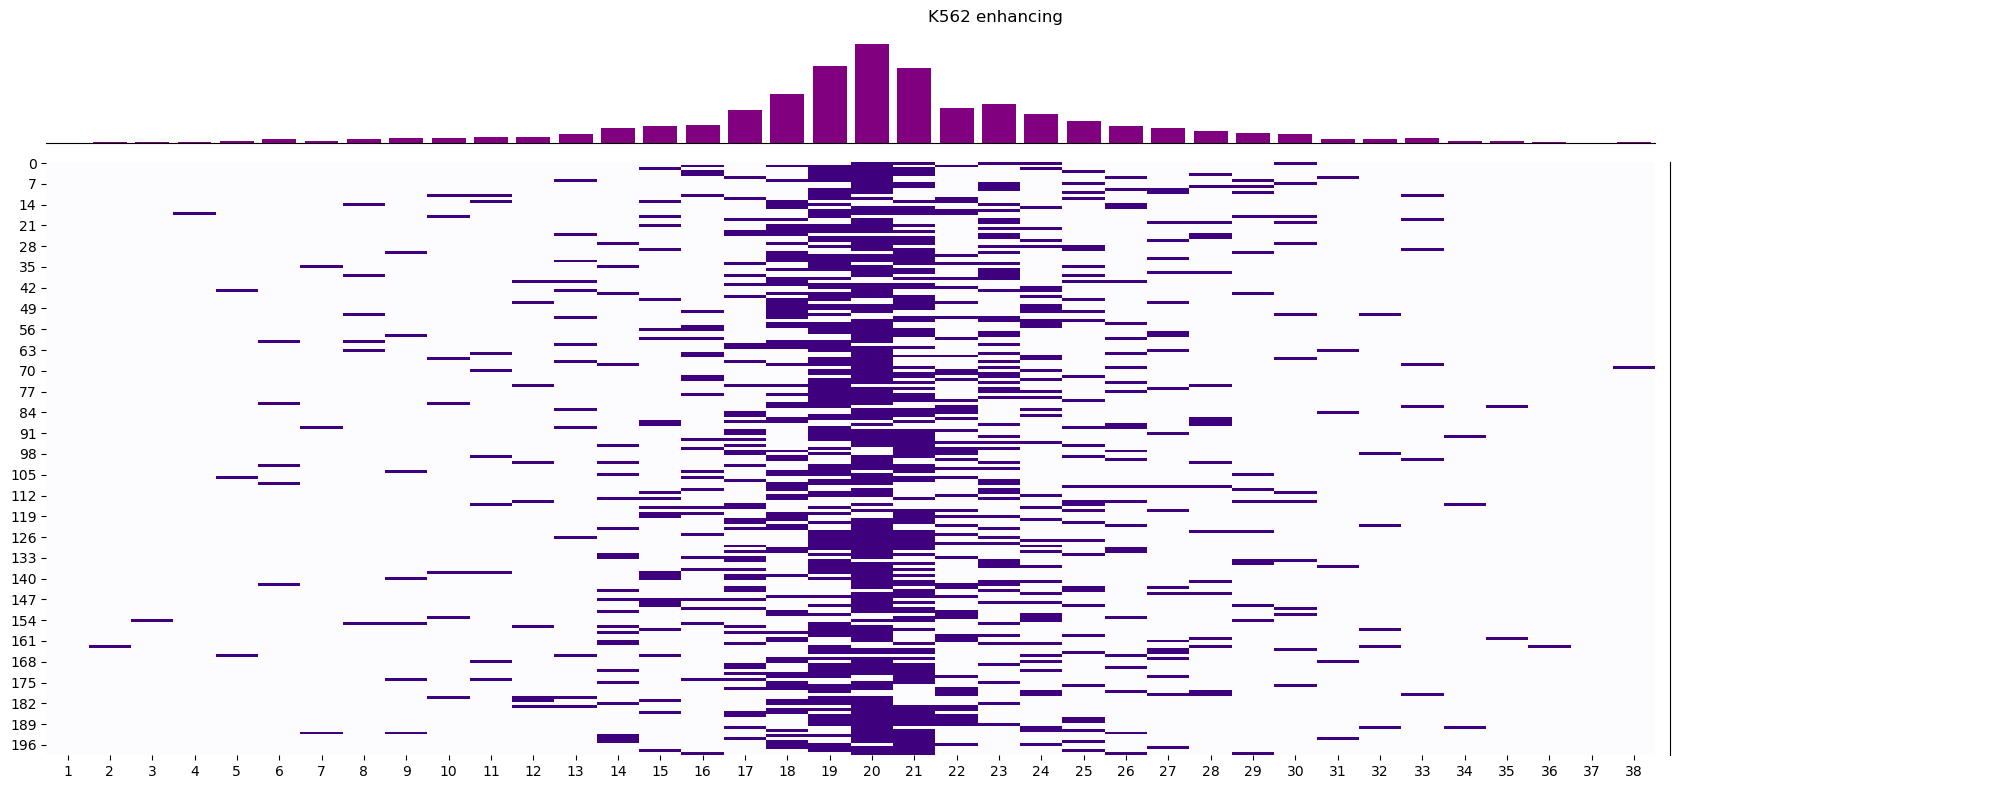

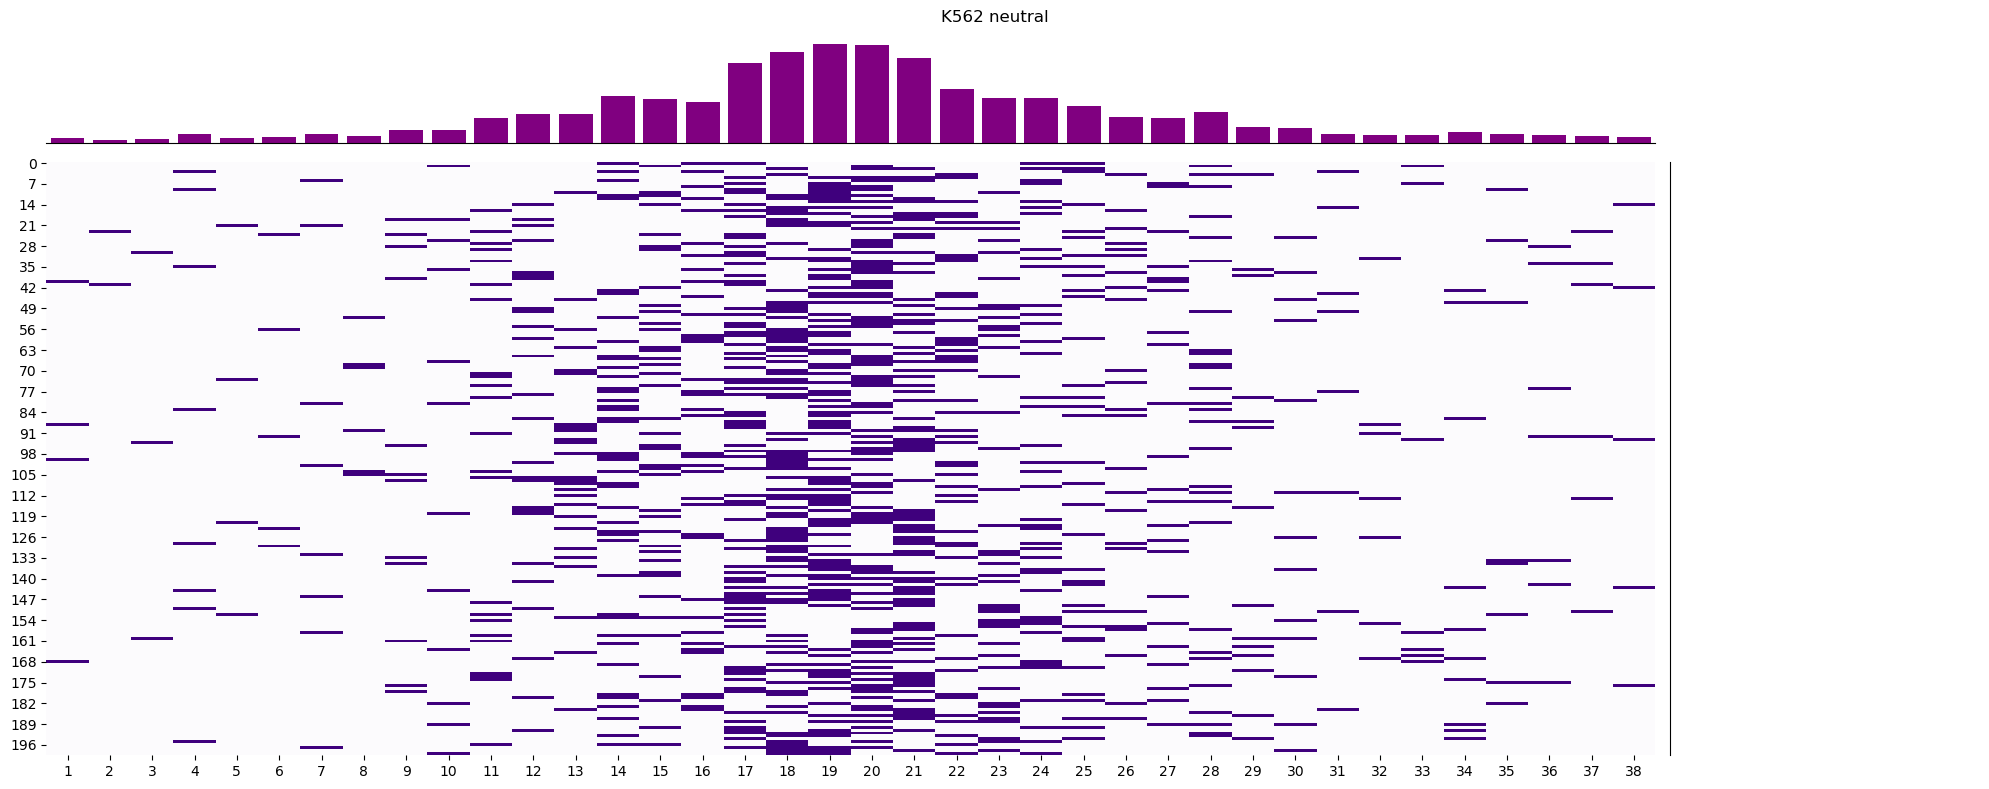

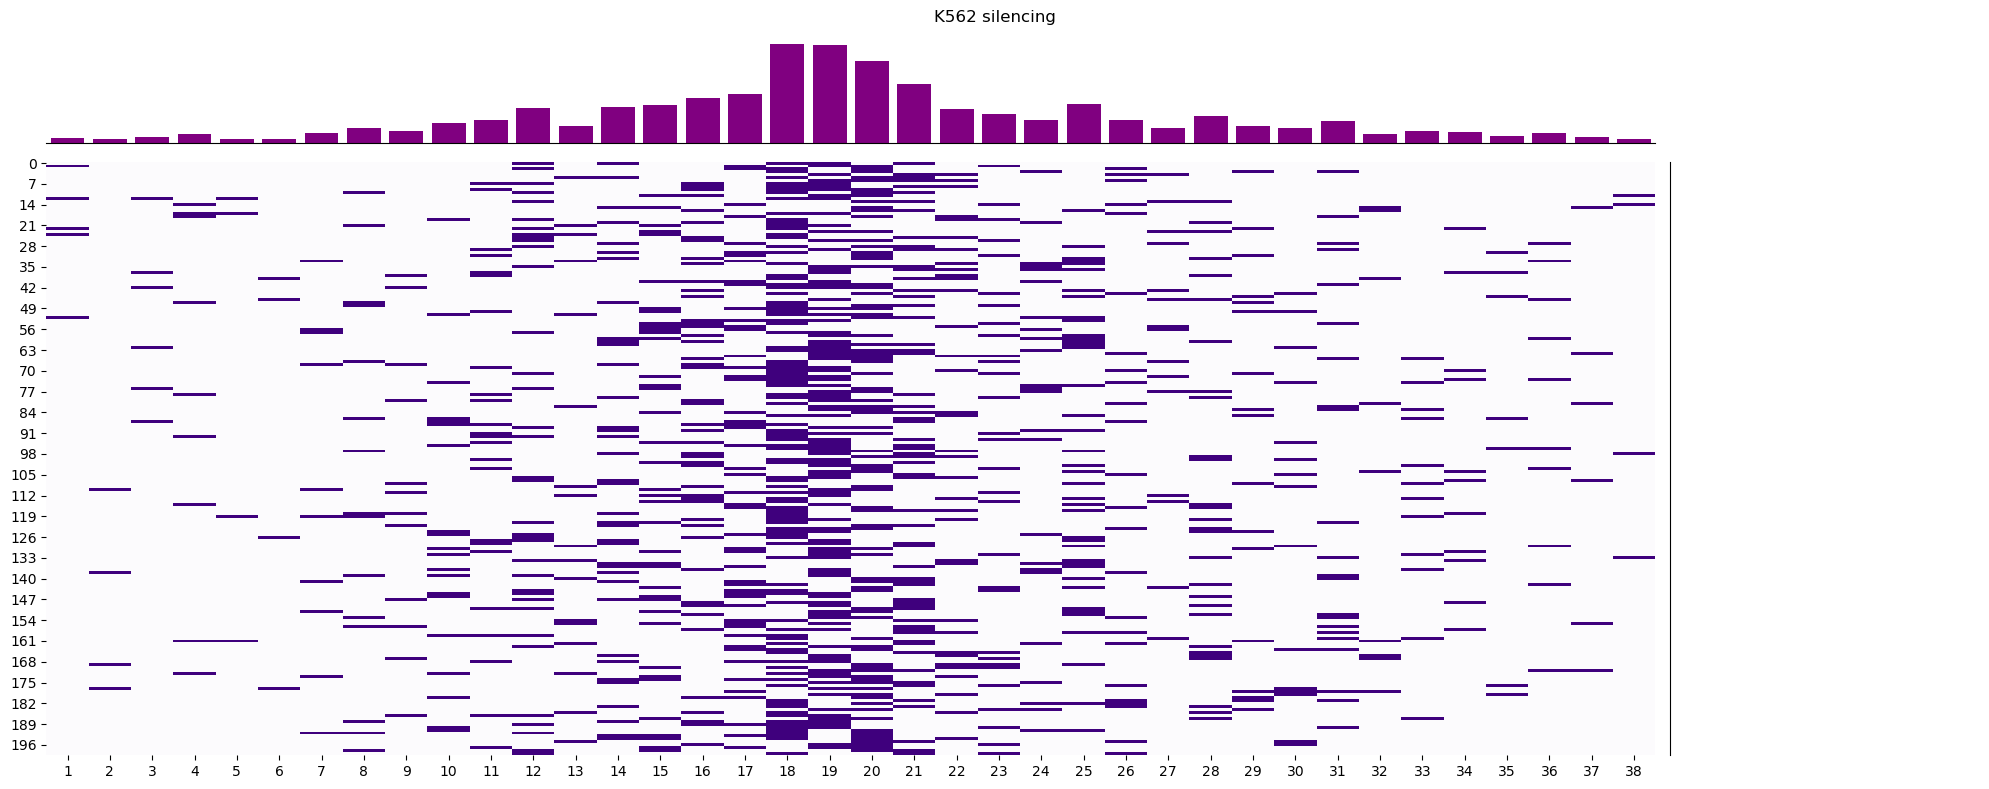

In [17]:
for cell, context_maps in location_maps.items():
    # fig, axes = plt.subplots(1, 3, figsize=[10, 3])
    for a, (context, v) in enumerate(context_maps.items()):
        df = pd.DataFrame(v)
        H, D = df.shape
        df = df.reset_index(names='sequence').melt(id_vars='sequence', var_name='position', value_name='Selected')
        
        df['position'] = [int(p) for p in df['position']]
        g = sns.jointplot(data=df, x='position', y='sequence', kind='hist', bins=(D, H))
        g.ax_marg_y.cla()
        g.ax_marg_x.cla()
        sns.heatmap(data=df['Selected'].to_numpy().reshape(D, H).T.astype('float'), ax=g.ax_joint, cbar=False, cmap='Purples')
        
        # g.ax_marg_y.barh(np.arange(0.5, H), df.groupby(['hour'])['Cost Dif.'].sum().to_numpy(), color='navy')
        g.ax_marg_x.bar(np.arange(0.5, D), df.groupby(['position'])['Selected'].sum().to_numpy(), color='purple')
        
        g.ax_joint.set_xticks(np.arange(0.5, D))
        g.ax_joint.set_xticklabels(range(1, D + 1), rotation=0)
        # g.ax_joint.set_yticks(np.arange(0.5, H))
        # g.ax_joint.set_yticklabels(range(H), rotation=0)
        
        # remove ticks between heatmao and histograms
        g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
        g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
        # remove ticks showing the heights of the histograms
        g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
        g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)
        
        g.fig.set_size_inches(20, 8)  # jointplot creates its own figure, the size can only be changed afterwards
        # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
        g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
        g.fig.suptitle(f'{cell} {context}')
        plt.tight_layout()

        plt.savefig(f'{pdf_dir}/enhancer_distribution_{cell_line}_{context}.pdf')
        plt.show()


# Greedy search 

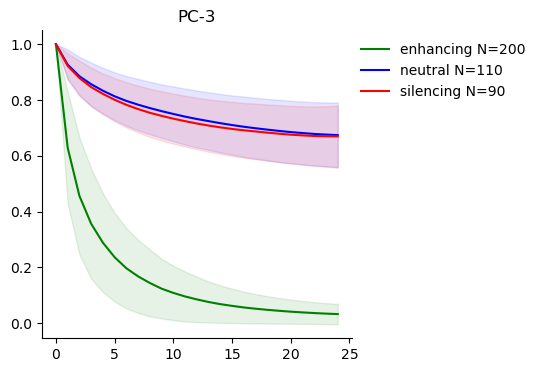

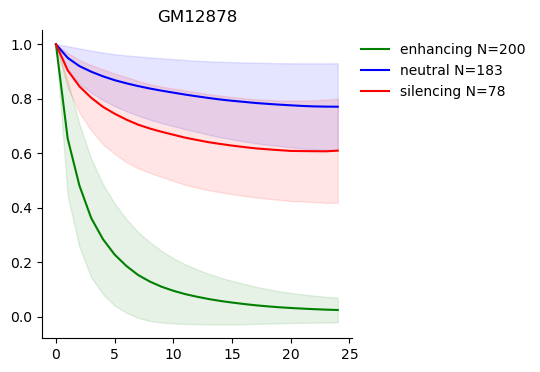

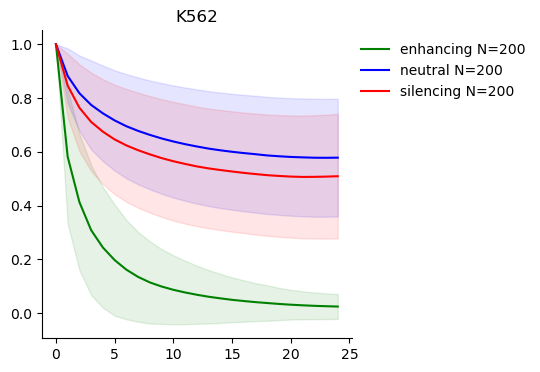

In [7]:
color_map = {'enhancing': 'g', 'neutral':'b', 'silencing':'r'}
for cell_line in cell_lines:


    fig, ax = plt.subplots(1, 1, figsize=[4,4])
    
    for context, data in result_summary[cell_line]['greedy search'].items():
        data = np.array(data)
        
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        color = color_map[context]
        ax.plot(mean, c=color, alpha=1, label=f'{context} N={data.shape[0]}')
        ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)

    plt.legend(frameon=False, bbox_to_anchor=[1.6,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)
    fig.savefig(f'{pdf_dir}/{cell_line}_enhancer_search.pdf')

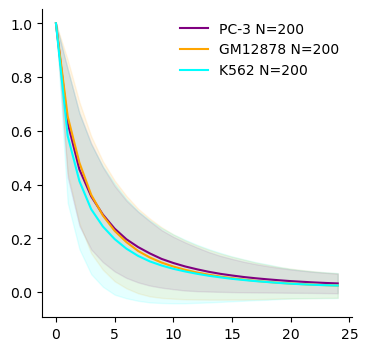

In [8]:
fig, ax = plt.subplots(1, 1, figsize=[4,4])
colors = ['purple', 'orange', 'cyan']
for i, cell_line in enumerate(cell_lines):
    context = 'enhancing'
    data = result_summary[cell_line]['greedy search'][context]
    data = np.array(data)
    plot_line_with_std(data, colors[i], f'{cell_line} N={data.shape[0]}')
    plt.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.savefig(f"{pdf_dir}/cell_line_comparison.pdf")


# Hypothetical additive model

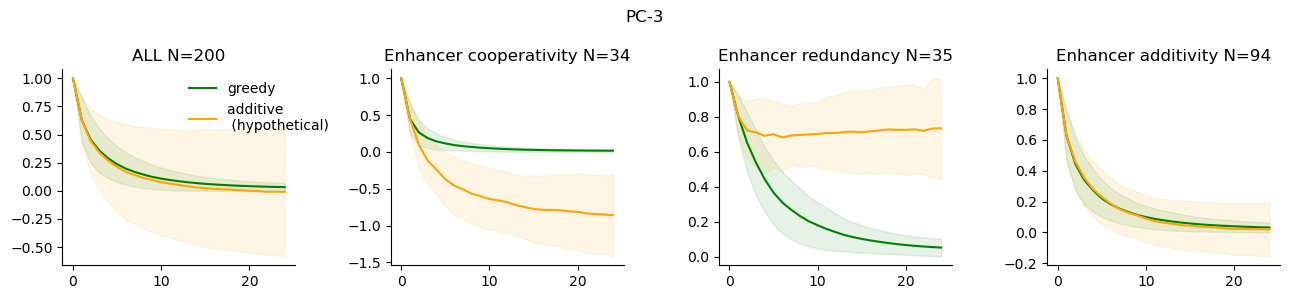

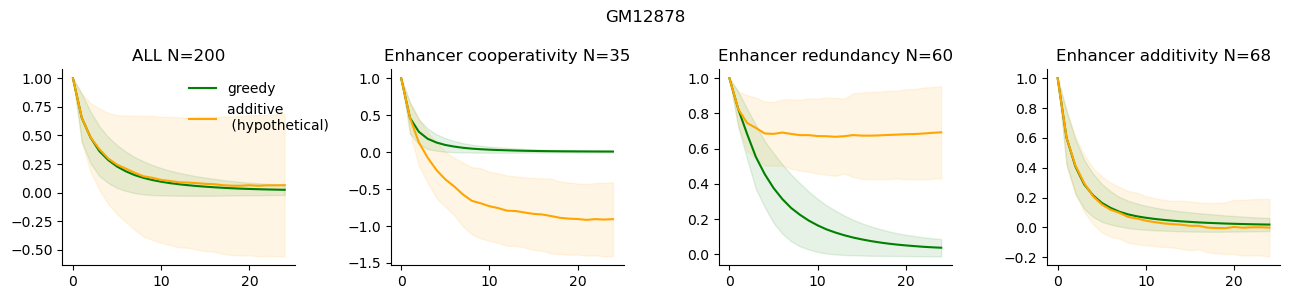

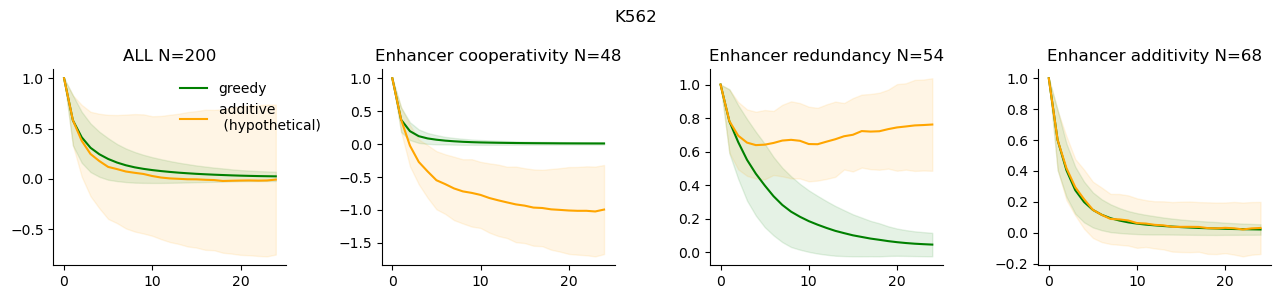

In [40]:
strata = {}
for cell in cell_lines:
    sign = []
    MSE = []
    enhancing_greedy = np.array(result_summary[cell]['greedy search']['enhancing'])
    enhancing_hyp = np.array(result_summary[cell]['hypothetical additive']['enhancing'])
    for trace, hypothetical_trace in zip(enhancing_greedy, enhancing_hyp):
        MSE.append(mean_squared_error(trace, hypothetical_trace))
        sign.append(np.mean(trace) - np.mean(hypothetical_trace))
    MSE = np.array(MSE) 

    colors = ['green', 'orange']
    labels = ['cooperative', 'additive']
    titles = ['ALL', 'Enhancer cooperativity', 'Enhancer redundancy', 'Enhancer additivity']
    # i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
    
    pos_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s>0 and m>0.1]
    neg_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s<0 and m>0.1]
    zero_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<0.05]
    strata[cell] = {'cooperativity': pos_points, 'redundancy': neg_points, 'additivity': zero_points}
    all_points = np.arange(len(sign))

    fig, axes = plt.subplots(1, len(titles), figsize=[13, 3])
    curve_labels = ['greedy', 'additive \n (hypothetical)']
    
    for p, points in enumerate([all_points, pos_points, neg_points, zero_points]):
        ax = axes[p]
        ax.set_title(f'{titles[p]} N={len(points)}')
        trace_set, hypothetical_trace_set = enhancing_greedy[points], enhancing_hyp[points]
        for i, t in enumerate([trace_set, hypothetical_trace_set]):
            
            t_mean = t.mean(axis=0)
            t_std = t.std(axis=0)
            ax.plot(t_mean, color=colors[i], alpha=1, label=curve_labels[i])
        
            ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    axes[0].legend(frameon=False, bbox_to_anchor=[1.2,1])
    plt.suptitle(cell)
    plt.tight_layout()
    fig.savefig(f'{pdf_dir}/{cell}_greedy_vs_additive.pdf')

# Example sequence trajectories and sorted effect sizes


K562


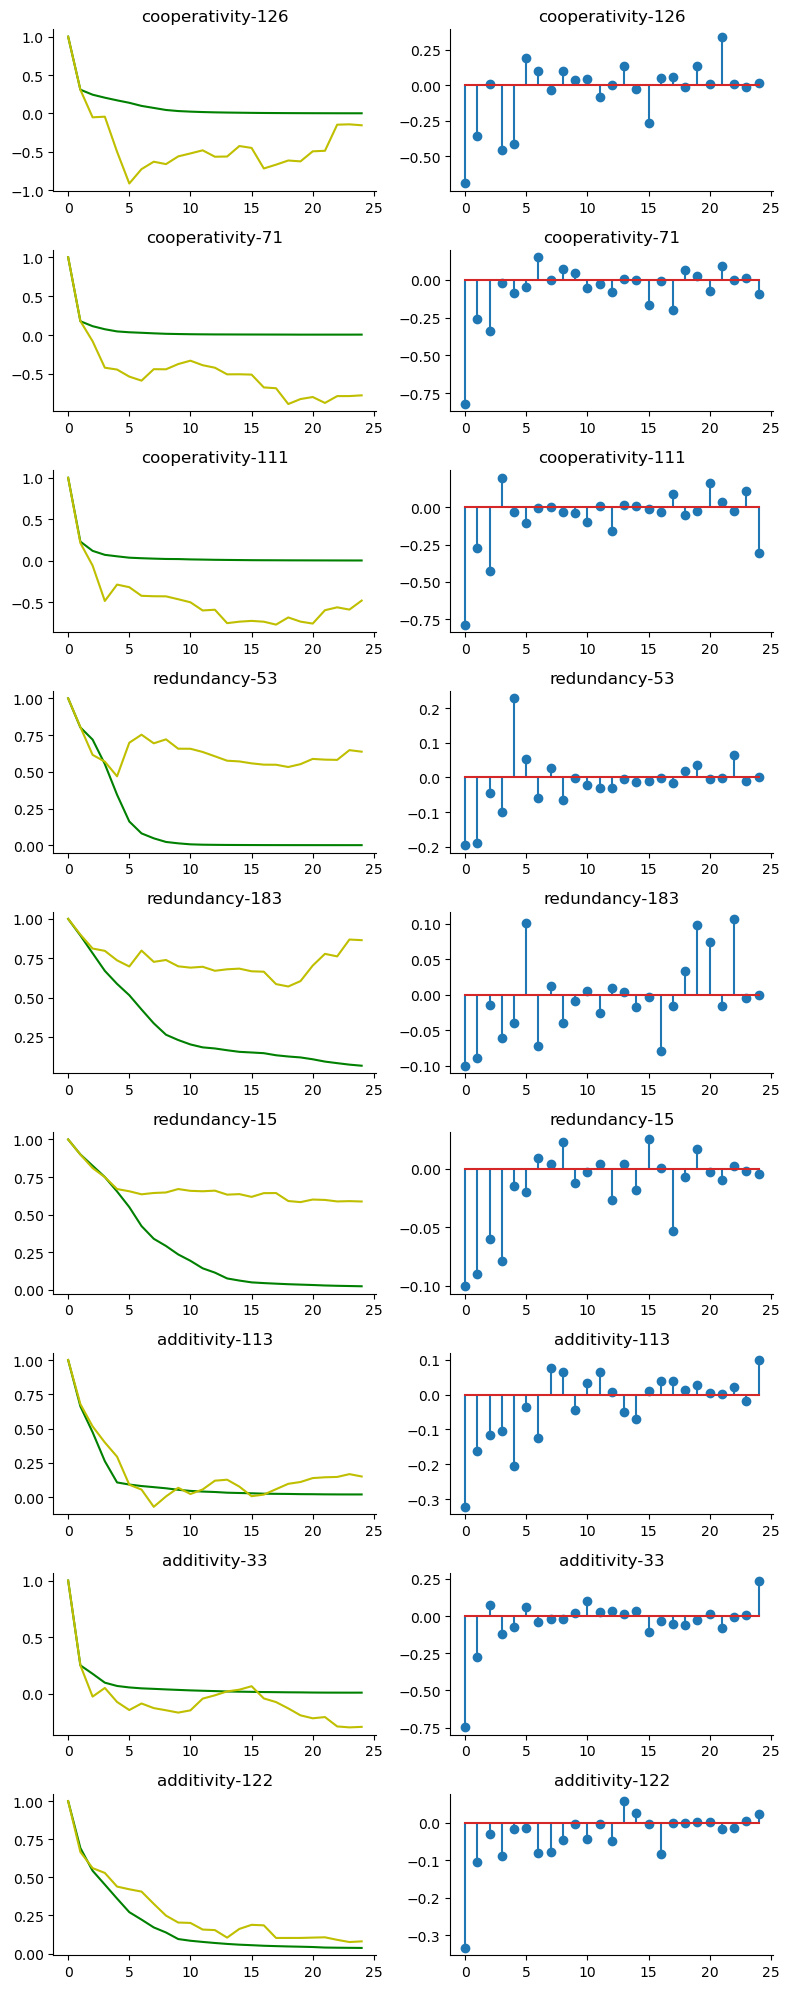

In [75]:
cell = 'K562'
cell_strata = {'cooperativity': [126, 71, 111],
              'redundancy': [53, 183, 15],
              'additivity': [113, 33, 122]}
print(cell)
fig, all_axes = plt.subplots(9, 2, figsize=[8, 20])
row = 0
for label, indeces in cell_strata.items():
    # np.random.seed(42)
    # subset = np.random.choice(one_stratum, 10, replace=False)
    # print(label)
    for i in indeces:
        axes = all_axes[row]

        axes[0].plot(result_summary[cell_line]['greedy search']['enhancing'][i], color='g')
        axes[0].plot(result_summary[cell_line]['hypothetical additive']['enhancing'][i], color='y')
        axes[1].stem(result_summary[cell]['sorted_effects']['enhancing'][i])
        axes[0].set_title(f"{label}-{i}")
        axes[1].set_title(f"{label}-{i}")

        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        # plt.savefig(f"{pdf_dir}/{label}-{i}")
        # plt.show()
        row += 1
plt.tight_layout()
fig.savefig(f"{pdf_dir}/example_sequences.pdf", bbox_inches='tight')

# Hypothetical multiplicative model

In [16]:
result_summary = {}
for cell_line in cell_lines:
    cell_line_res_paths = glob.glob(f'../results/higher_order_test_min/{model_name}/{cell_line}/*pickle')
    context_df = pd.read_csv(f'../results/summary_csvs/{model_name}/{cell_line}_selected_contexts.csv')
    traces = {k:[] for k in context_df['context'].unique()}
    hypothetical_traces = {k:[] for k in context_df['context'].unique()}
    for _, row in context_df.iterrows():
        res_path = f"../results/higher_order_test_min/{model_name}/{cell_line}/{row['path'].split('/')[-1]}"
        raw_res = utils.read_pickle(res_path)
        res = {}
        for i in raw_res.keys():
            res[i] = {}
            for k, v in raw_res[i].items():
                if 'pred' in k:
                    res[i][k] = np.log(v) 
                else:
                    res[i][k] = v
        wt = res[0]['initial_pred']
        
        traces[row['context']].append([res[i]['initial_pred'] for i in res.keys()])
        ####hypothetical additive model
        greedy_search_order = [np.argwhere(np.array(cre_tiles) == res[i]['selected_tile'])[0][0] for i in res.keys()]
        mutant_predictions_first_iter = res[0]['preds'].mean(axis=-1)
        
        effect_sizes_first_iter = mutant_predictions_first_iter - wt
        sorted_effect_first_iter = effect_sizes_first_iter[greedy_search_order]
        sum_of_effects = np.cumsum(sorted_effect_first_iter) 
        hypothetical_trace = wt + sum_of_effects
        hypothetical_trace = np.concatenate([[wt], hypothetical_trace]) #/ wt
        
        hypothetical_traces[row['context']].append(hypothetical_trace[:-1])
    result_summary[cell_line] = {'greedy search': traces, 'hypothetical additive': hypothetical_traces}

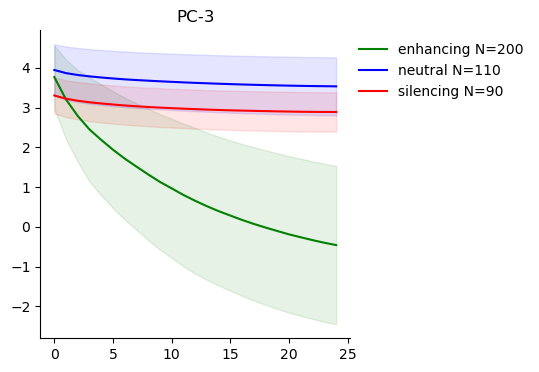

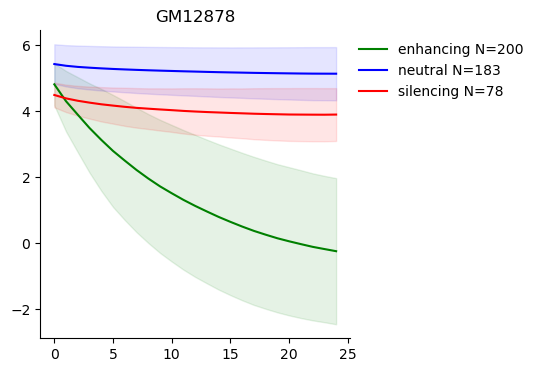

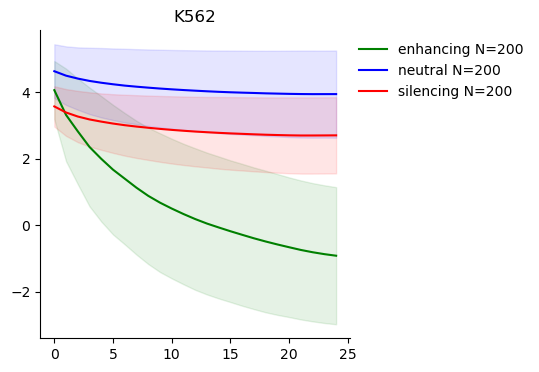

In [17]:
color_map = {'enhancing': 'g', 'neutral':'b', 'silencing':'r'}
for cell_line in cell_lines:


    fig, ax = plt.subplots(1, 1, figsize=[4,4])
    
    for context, data in result_summary[cell_line]['greedy search'].items():
        data = np.array(data)
        
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        color = color_map[context]
        ax.plot(mean, c=color, alpha=1, label=f'{context} N={data.shape[0]}')
        ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)

    plt.legend(frameon=False, bbox_to_anchor=[1.6,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)
    plt.show()

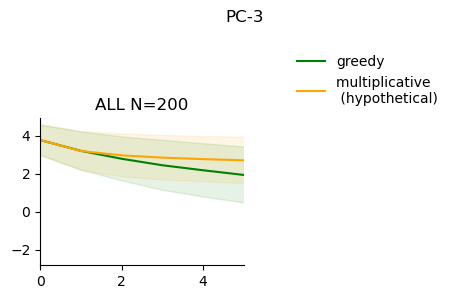

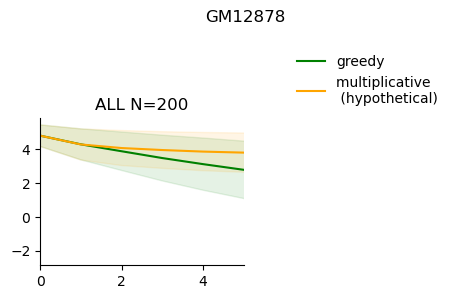

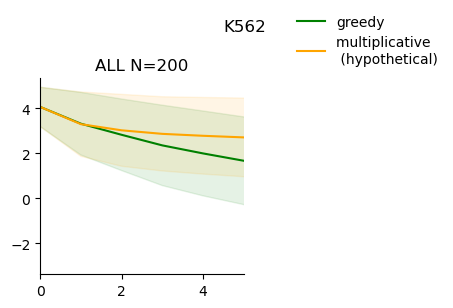

In [18]:
for cell in cell_lines:

    sign = []
    MSE = []
    enhancing_greedy = np.array(result_summary[cell]['greedy search']['enhancing'])
    enhancing_hyp = np.array(result_summary[cell]['hypothetical additive']['enhancing'])
    for trace, hypothetical_trace in zip(enhancing_greedy, enhancing_hyp):
        MSE.append(mean_squared_error(trace, hypothetical_trace))
        sign.append(np.mean(trace) - np.mean(hypothetical_trace))
    MSE = np.array(MSE) 

    colors = ['green', 'orange']
    labels = ['cooperative', 'additive']
    titles = ['ALL']#, 'Enhancer cooperativity', 'Enhancer redundancy', 'Enhancer additivity']
    # i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
    
    pos_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s>0 and m>0.1]
    neg_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s<0 and m>0.1]
    zero_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<0.05]
    all_points = np.arange(len(sign))

    fig, axes = plt.subplots(1, len(titles), figsize=[5, 3])
    curve_labels = ['greedy', 'multiplicative \n (hypothetical)']
    
    for p, points in enumerate([all_points]):#, pos_points, neg_points, zero_points]):
        ax = axes#[p]
        ax.set_title(f'{titles[p]} N={len(points)}')
        trace_set, hypothetical_trace_set = enhancing_greedy[points], enhancing_hyp[points]
        for i, t in enumerate([trace_set, hypothetical_trace_set]):
            
            t_mean = t.mean(axis=0)
            t_std = t.std(axis=0)
            ax.plot(t_mean, color=colors[i], alpha=1, label=curve_labels[i])
        
            ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    ax.legend(frameon=False, bbox_to_anchor=[1.2,1])
    plt.suptitle(cell)
    plt.xlim(0,5)
    plt.tight_layout()

# 2nd point comparison


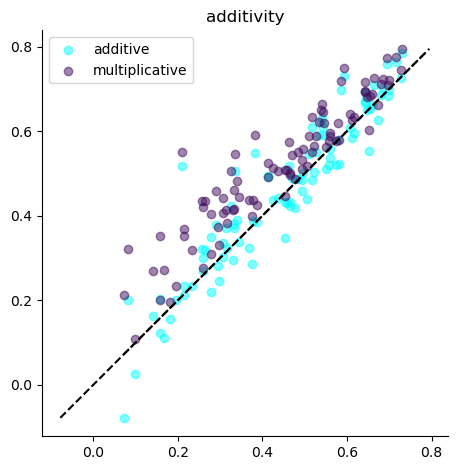

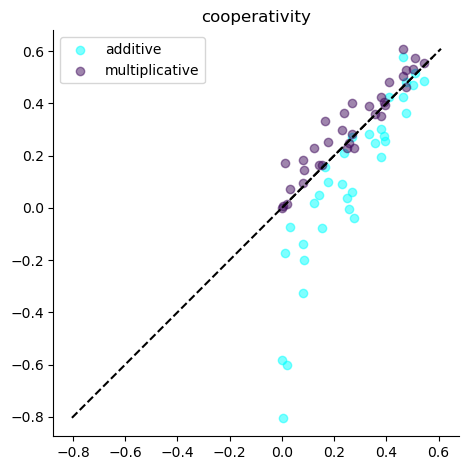

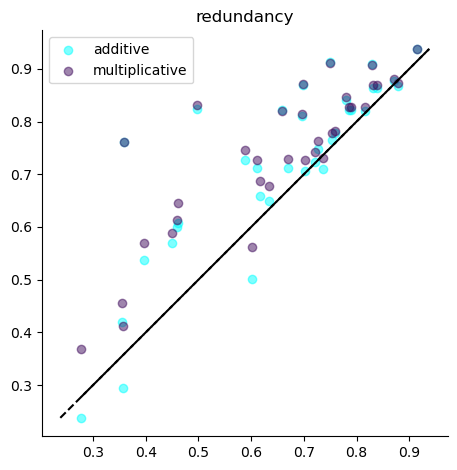

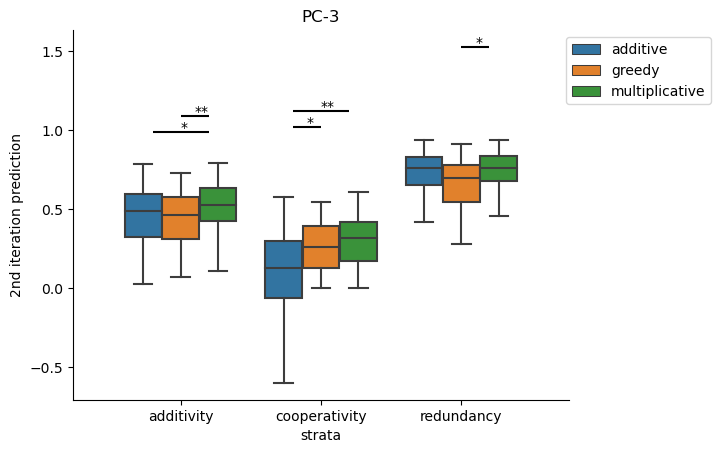

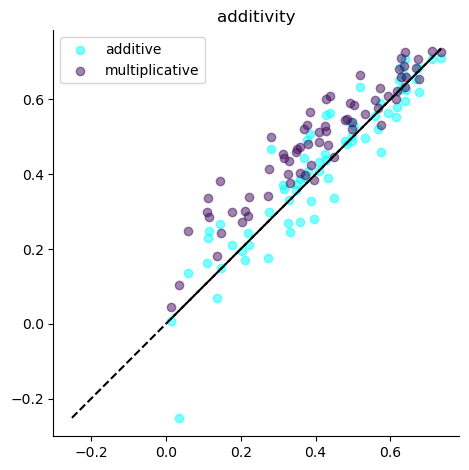

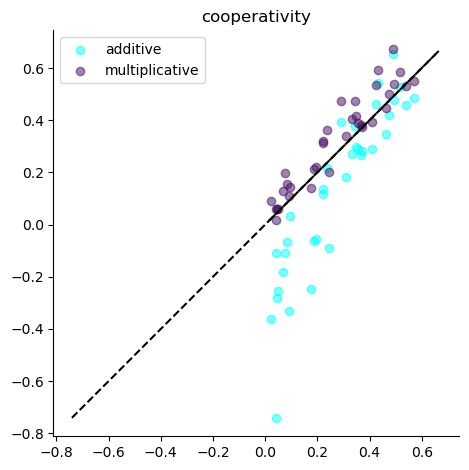

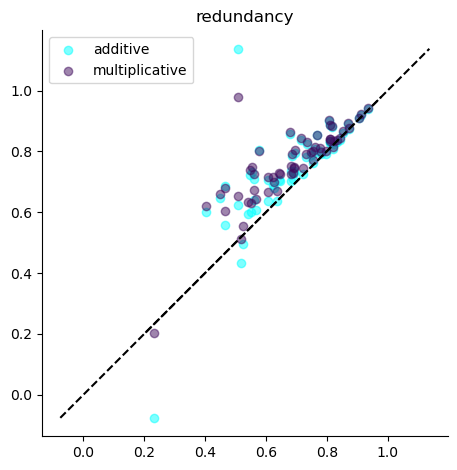

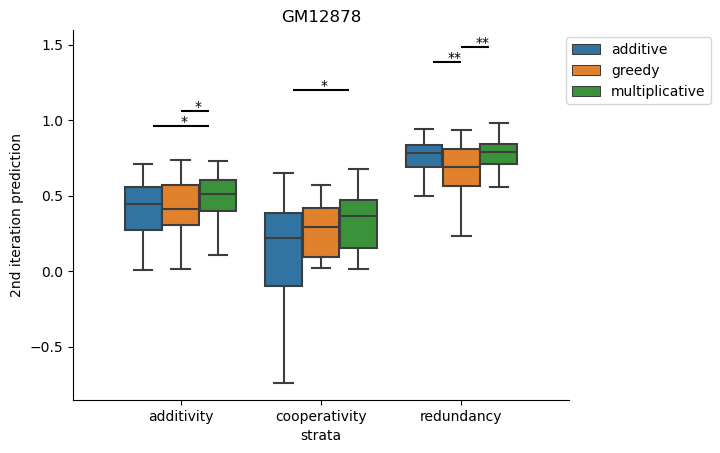

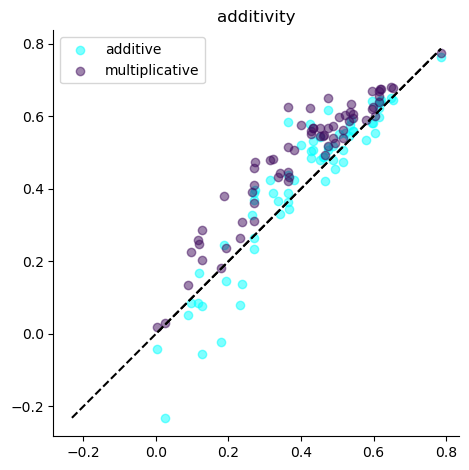

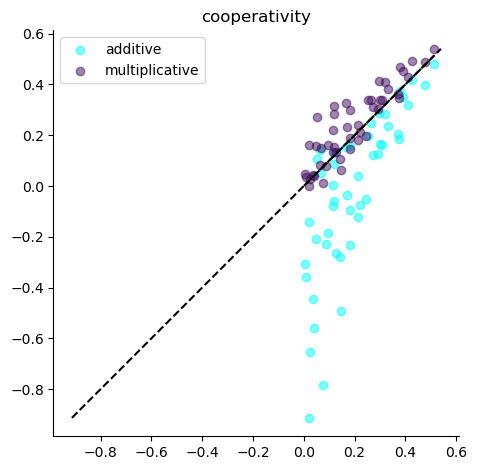

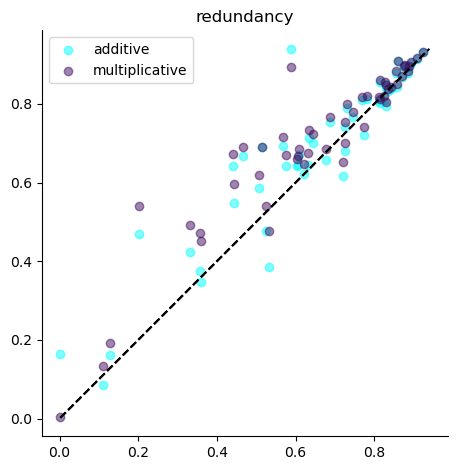

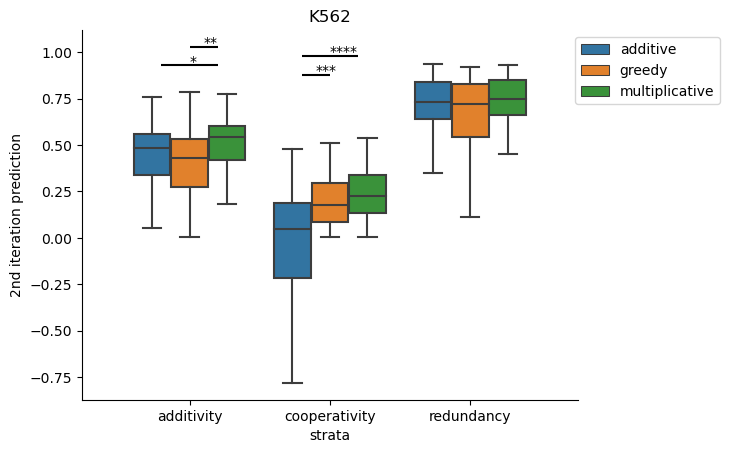

In [644]:
order=['additivity', 'cooperativity', 'redundancy']
hue_order=['additive', 'greedy', 'multiplicative']

for cell_line, vals in result_summary.items():
    second_it = vals['second_it']
    context = 'enhancing'
    # for context in second_it.keys():
    hypothetical_additive = []
    hypothetical_multiplicative = []
    greedy = []
    for d, data_point in enumerate(second_it[context]):
        wt, (p1, p2), greedy_res = data_point
        log_wt, (log_p1, log_p2), _ = [np.log(i) for i in data_point.copy()]
        hypothetical_additive.append((wt + (p1 - wt) + (p2 - wt))/wt)
        hypothetical_multiplicative.append((np.exp(log_wt + (log_p1 - log_wt) + (log_p2 - log_wt)))/wt)
        greedy.append(greedy_res/wt)

    df = pd.DataFrame([hypothetical_additive, hypothetical_multiplicative, greedy]).T
    df.columns = ['additive', 'multiplicative', 'greedy']
    labels = np.array(['' for _ in range(df.shape[0])]).astype('U20')
    for s, ind in strata[cell_line].items():
        labels[ind] = s  
    df['strata'] = labels
    df = df[df['strata']!='']
    annotations = []
    for s_i, stratum in enumerate(order):
        df_stratum = df[df['strata']==stratum]
        pair_indexes = list(itertools.combinations(range(3), 2))

        
        for p, pair_index in enumerate(pair_indexes):

            
            model_type1, model_type2 = hue_order[pair_index[0]], hue_order[pair_index[1]]
            p_sign = convert_pvalue_to_asterisks(scipy.stats.mannwhitneyu(df_stratum[model_type1], df_stratum[model_type2])[1])
            if p_sign!= 'ns':
                

                Q1 = np.quantile(df_stratum['multiplicative'], 0.25)
                Q3 = np.quantile(df_stratum['multiplicative'], 0.75)
                    
                IQR = Q3 - Q1
                lim = Q3 + 1.5 * IQR
                annotations.append([s_i-0.2, pair_index, p_sign, lim*1.05])
        fig, ax = plt.subplots(1, 1)
        
        for p, (x, y) in enumerate([['greedy', 'additive'], ['greedy', 'multiplicative']]):

            
        
            ax.set_aspect('equal', adjustable='box')
            ax.scatter(df_stratum[x], df_stratum[y],color=['cyan', '#400c5d'][p], label=y, alpha=0.5)
            # sns.scatterplot(data=df_stratum, x=x, y=y, edgecolor=None, alpha=0.3, color="#400c5d", ax=ax)
            min_point, max_point = df_stratum[[x, y]].min().min(), df_stratum[[x, y]].max().max()
            ax.plot([min_point, max_point], [min_point, max_point], color='k', linestyle='--')
            ax.set_title(stratum)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        plt.legend()
        plt.tight_layout()
        plt.show()
    df_square = df.copy()
    df = df.melt(id_vars='strata', var_name='method', value_name='2nd iteration prediction')

    ax=sns.boxplot(data=df, x='strata', y='2nd iteration prediction', hue='method', showfliers=False, 
                order=order, hue_order=hue_order)
    # plt.title(f"{cell_line} {context}")
    counter = 0    
    for (s_i, pair_index, p_sign, y_max) in annotations:
        x1, x2 = s_i+pair_index[0]*0.2, s_i+pair_index[1]*0.2
        y = y_max+counter
        plt.hlines(y, x1, x2, color='k')
        plt.annotate(p_sign, ((x1+x2)/2, y))
        counter += 0.1
    plt.title(cell_line)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(bbox_to_anchor=[1.3, 1])



    plt.show()
